In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib

import warnings
warnings.simplefilter("ignore")

import featuretools as ft
from woodwork.logical_types import Categorical, Double, Datetime, Age

from catboost import CatBoostClassifier, Pool

import shap

from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score

### Обьединим главный датасет с дополнительными данными

In [2]:
train = pd.read_pickle('task_intro')

rides_info = pd.read_csv(r"C:\Users\savus\ML\Задача\rides_info.csv")
driver_info = pd.read_csv(r"C:\Users\savus\ML\Задача\driver_info.csv")
fix_info = pd.read_csv(r"C:\Users\savus\ML\Задача\fix_info.csv")

# обьеденим данные для визуализации
rides_info_visualization = rides_info.merge(train, on="car_id", how="right")
rides_info_visualization = rides_info_visualization.merge(driver_info, on="user_id", how="left")

display(rides_info_visualization)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max_x,stop_times,...,speed_max_y,user_ride_quality_median,deviation_normal_mean,user_uniq,age,user_rating,user_rides,user_time_accident,sex,first_ride_date
0,n14703870u,y13744087j,Q1Z,2020-01-01,5.72,220,3514,42,NaN,6,...,180.855726,0.023174,-0.120391,170,38,7.4,268,2.0,0,2019-9-7
1,W18144322F,y13744087j,M1P,2020-01-01,2.52,37392,523483,45,53.000000,2,...,180.855726,0.023174,-0.120391,170,46,6.7,643,3.0,0,2020-7-28
2,Q11878237R,y13744087j,D1j,2020-01-02,7.17,45,444,54,82.000000,0,...,180.855726,0.023174,-0.120391,170,49,8.4,161,NaN,0,2020-3-23
3,r92216797N,y13744087j,s1D,2020-01-02,6.19,10,105,35,40.000000,0,...,180.855726,0.023174,-0.120391,170,37,8.3,1548,NaN,1,2018-7-7
4,s16802374w,y13744087j,d1v,2020-01-03,3.14,49,486,54,85.845615,1,...,180.855726,0.023174,-0.120391,170,22,9.0,36,15.0,1,2019-11-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406633,e58324335h,z-1337463D,T1c,2020-03-30,5.08,46,408,49,87.000000,0,...,171.000000,-14.151230,21.628856,173,38,8.4,969,9.0,0,2021-1-20
406634,P21838441I,z-1337463D,B1g,2020-03-31,5.27,43,553,85,90.429573,0,...,171.000000,-14.151230,21.628856,173,28,8.4,1070,NaN,1,2018-11-11
406635,D22372203c,z-1337463D,q1t,2020-03-31,6.03,6,54,40,66.000000,2,...,171.000000,-14.151230,21.628856,173,30,8.5,190,23.0,1,2020-4-3
406636,l11688888v,z-1337463D,b1B,2020-04-01,2.89,46,455,40,113.000000,0,...,171.000000,-14.151230,21.628856,173,28,8.0,672,4.0,0,2019-5-20


### Попробуем найти инсайды в данных с помощью визуализации

Text(0.5, 1.0, 'Тепловая карта корреляции')

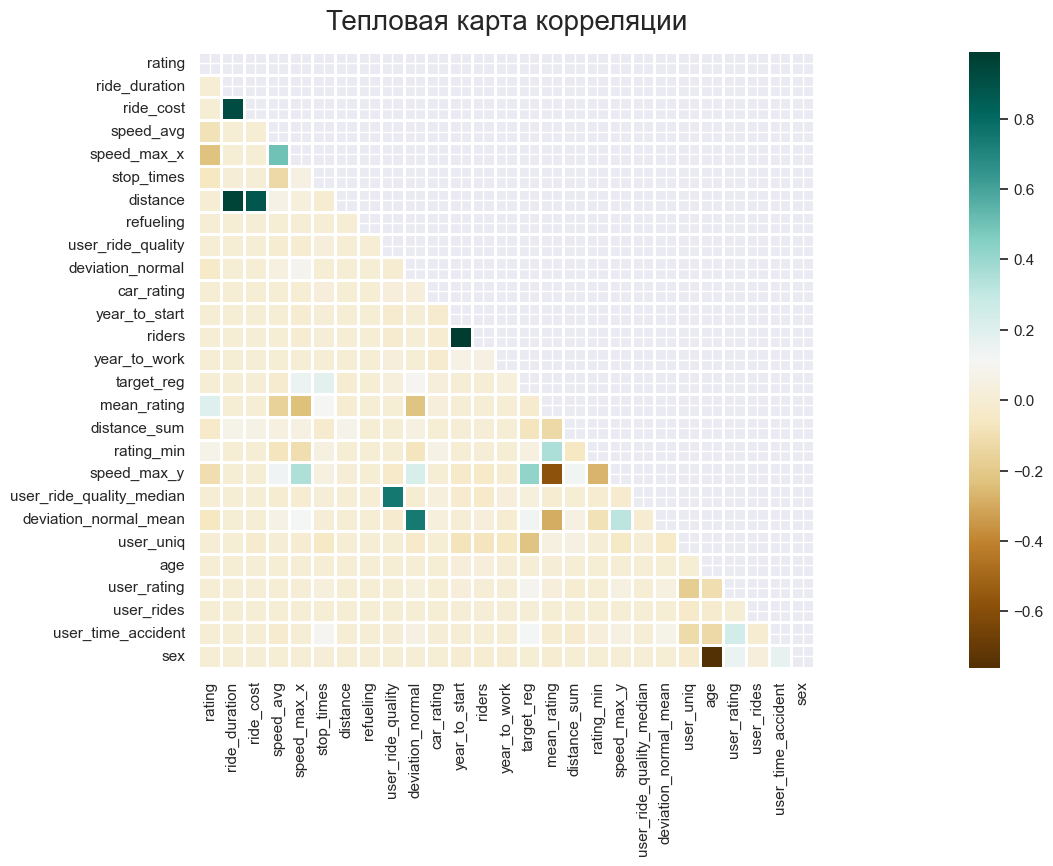

In [3]:
sns.set_style("whitegrid")
sns.set(rc={"figure.figsize": (40, 8)});

# маска для получения треугольной тепловой карты
mask = np.triu(np.ones_like(rides_info_visualization.corr(numeric_only=True), dtype=bool))

heatmap = sns.heatmap(
    rides_info_visualization.corr(numeric_only=True).round(2),
    annot=True,
    square=True,
    cmap="BrBG",
    cbar_kws={"fraction": 0.01},
    linewidth=1,
    fmt='g',  
    mask=mask,
)

heatmap.set_title(
    "Тепловая карта корреляции", fontdict={"fontsize": 20}, pad=16
)



### По большей части, наблюдаются достаточно тривиальные закономерности, например, чем раньше машина начала использоваться, тем больше разных водителей совершали на ней поездки. Исходя из значений корредяции, значение таргета в большей степени зависит от количества остановок в поездках, максимальной скорости и показателя датчиков

car_type
economy     1536
standart     599
business     117
premium       85
Name: count, dtype: int64


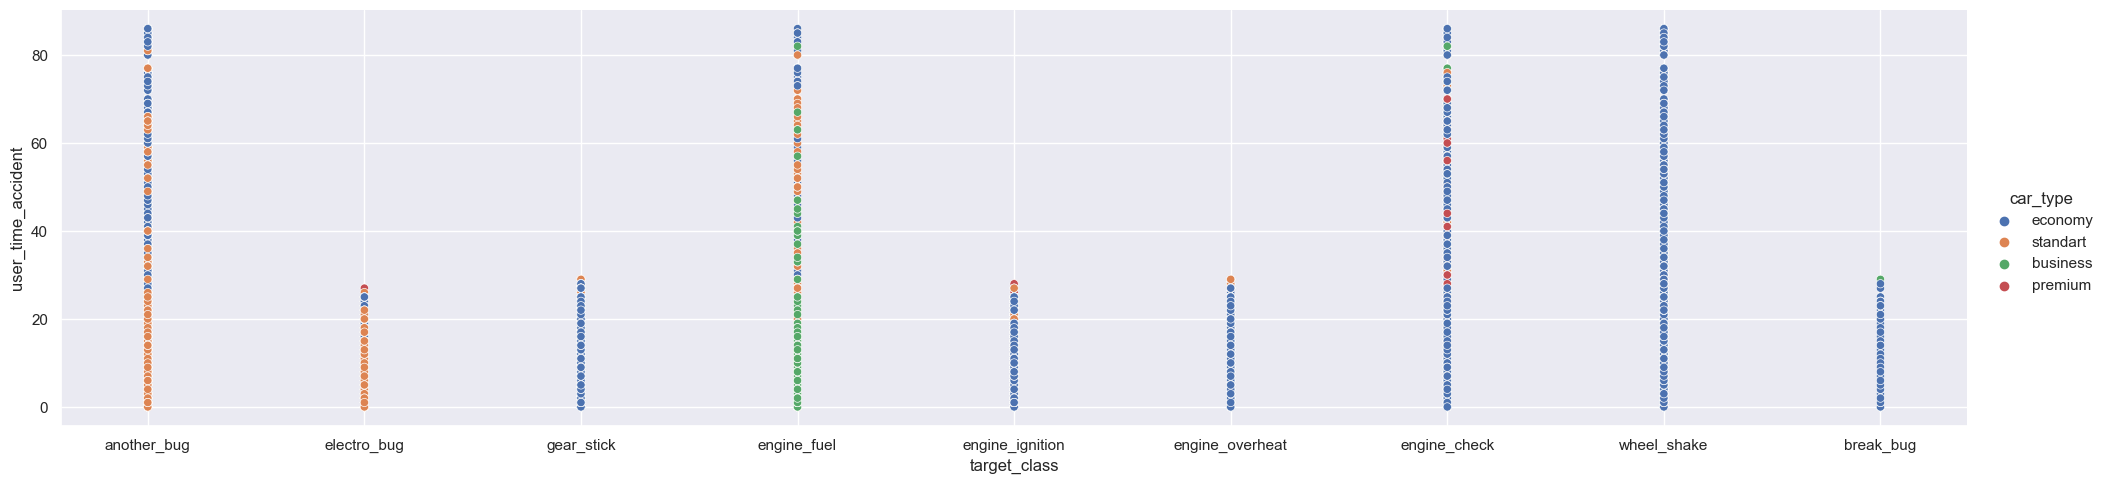

In [4]:
g = sns.relplot(
    data=rides_info_visualization,
    x="target_class",    
    y="user_time_accident",    
    hue="car_type",
    kind="scatter",
    aspect=4,
    alpha=1,
);
print(train['car_type'].value_counts())

### Видно, что тип поломки зависит от класса машины: например, wheel_shake бывает только у машин эконом класса, gear stick, engine ignition, engine overheat и break bug преимущественно у эконом класса. При этом машины эконом класса состовляют больше 65% автопарка

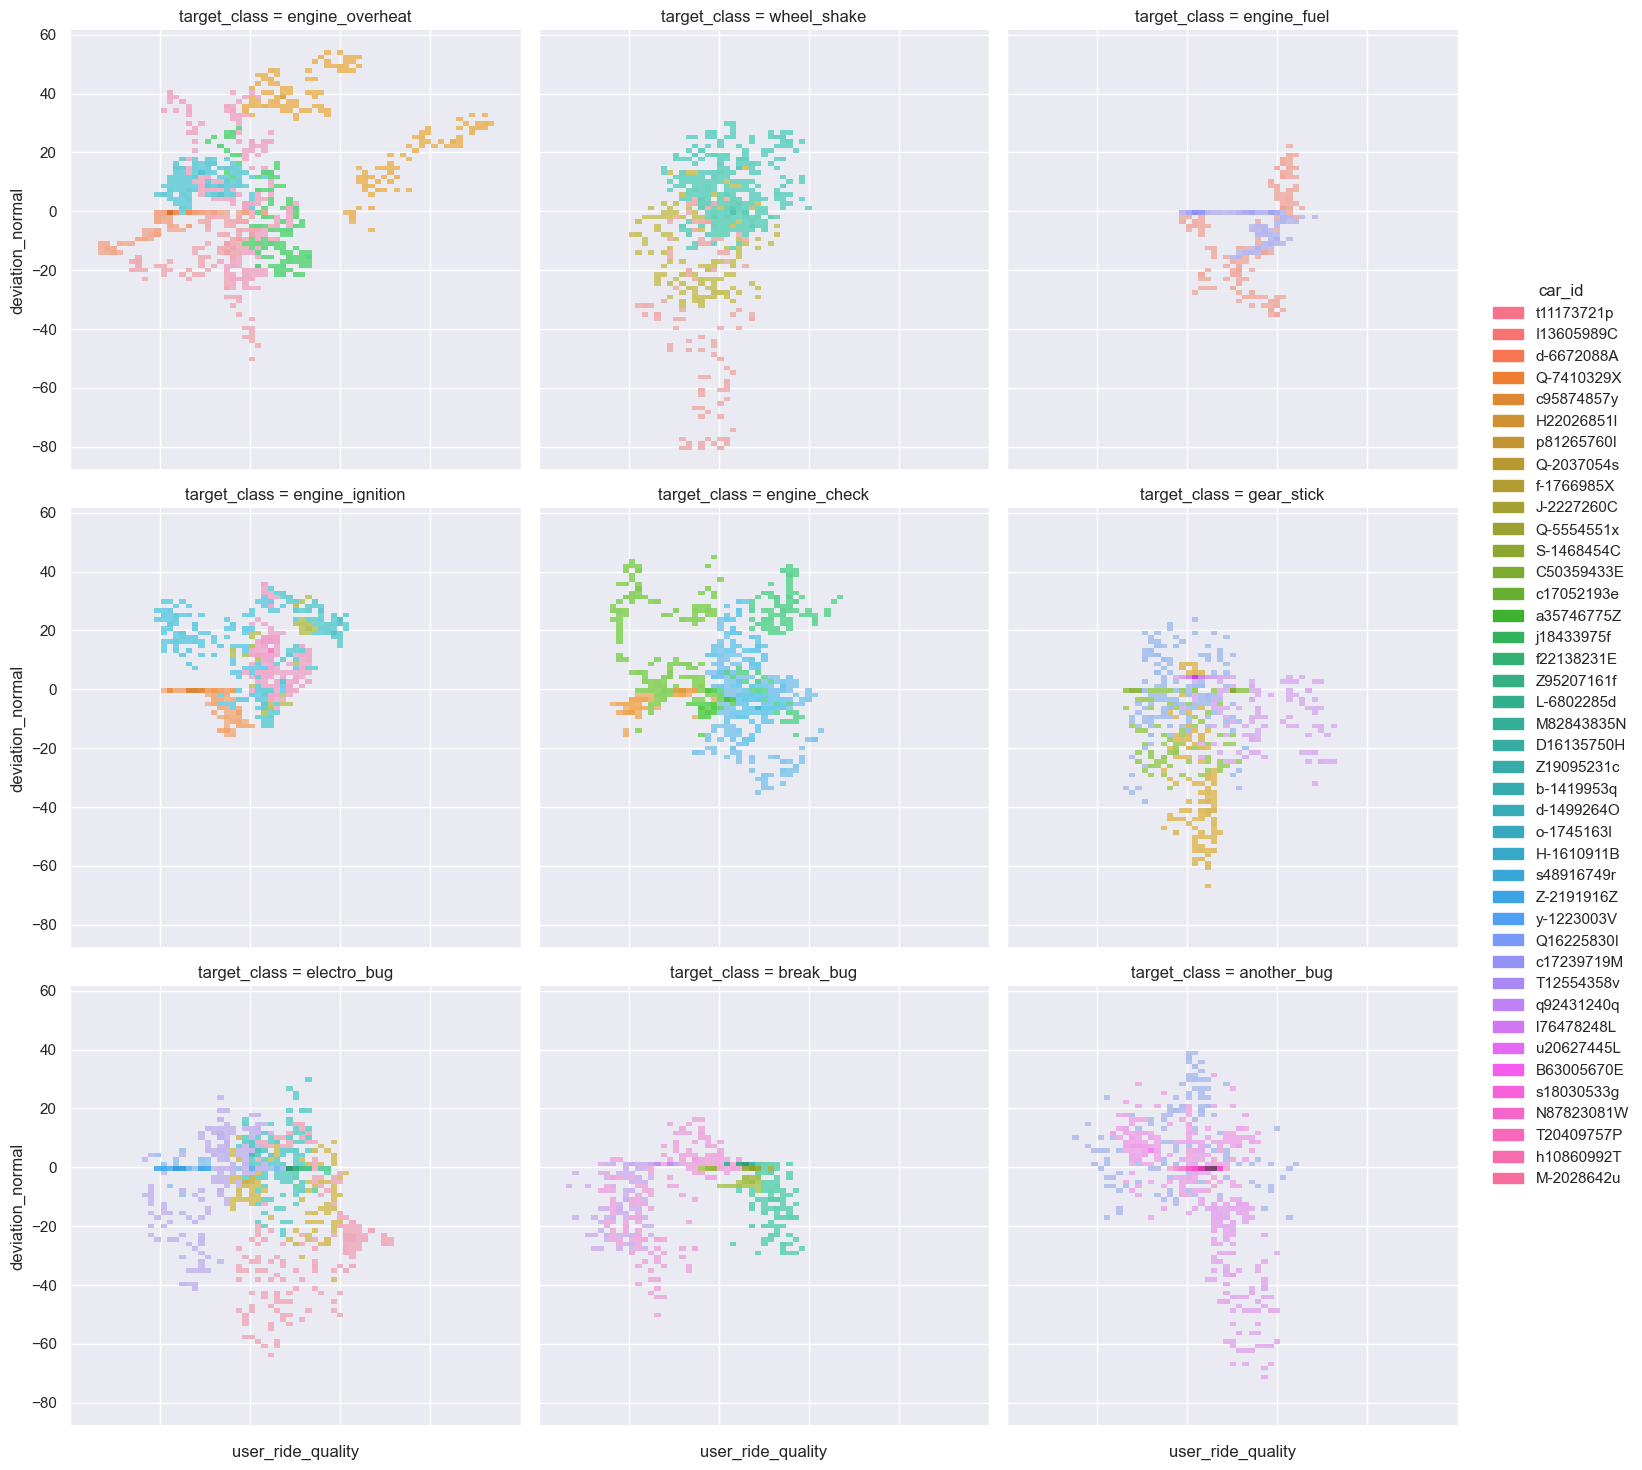

In [5]:
# сэмплируем 100 строк
sample = rides_info_visualization[rides_info["car_id"].isin(rides_info_visualization.sample(100, random_state=10).car_id.unique()[:100])]

g = sns.displot(
    data=sample,
    
    x="user_ride_quality",
    y="deviation_normal",
    
    aspect=1,
    
    hue="car_id",
    col="target_class",
    
    col_wrap=3,
    
).set_xticklabels(rotation=45, horizontalalignment="right")

### Какого-то хорошего инсайда из такой оценки не получить, видны распределения кластеров с большой дисперсией 

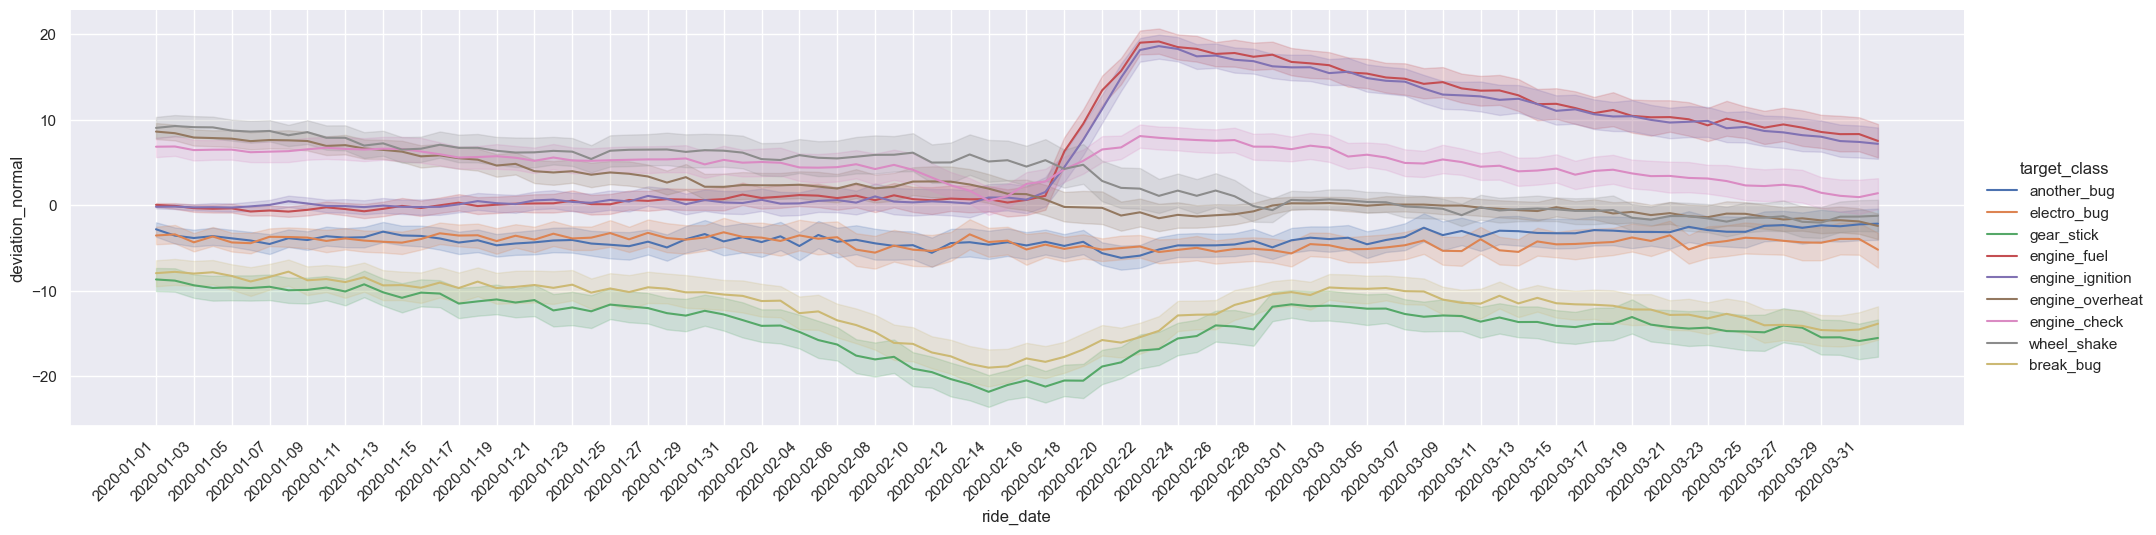

In [6]:
g = sns.relplot(
    data=rides_info_visualization,
    x="ride_date",
    y="deviation_normal",
    hue="target_class",
    kind="line", 
    aspect=4,
)

g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

### Показатели датчиков во времени. Проблемы с зажигаем двигателя и моторным маслом можно определять по линии перегиба. Так же по минимальному значению можно попытаться определить два других класса поломок: break_bug и gear_stick

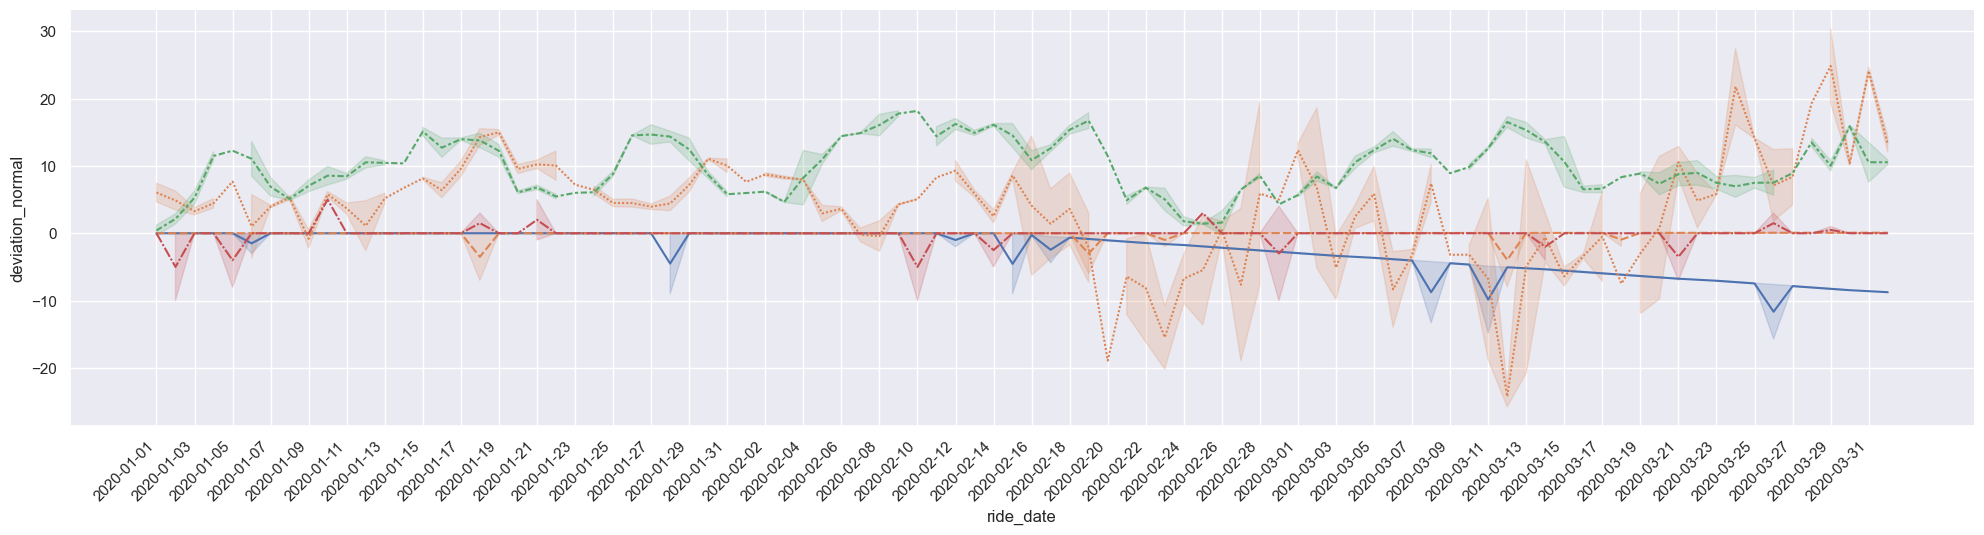

In [7]:
# сэмплируем 10 строк
sample = rides_info_visualization[rides_info["car_id"].isin(rides_info_visualization.sample(100, random_state=10).car_id.unique()[:10])]

g = sns.relplot(
    data=sample,
    
    x="ride_date",
    y="deviation_normal",
    
    hue="target_class",
    style="car_id",
    
    legend=False,
    kind="line",
    aspect=4,
)
g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

### На десяти случайно выбранных сэмплах можно оценить поведение показателей датчиков от времени. Можно наблюдать ярко выраженные перегибы, нисходящие тренды или примерно равномерное распределение показателей датчиков от времени

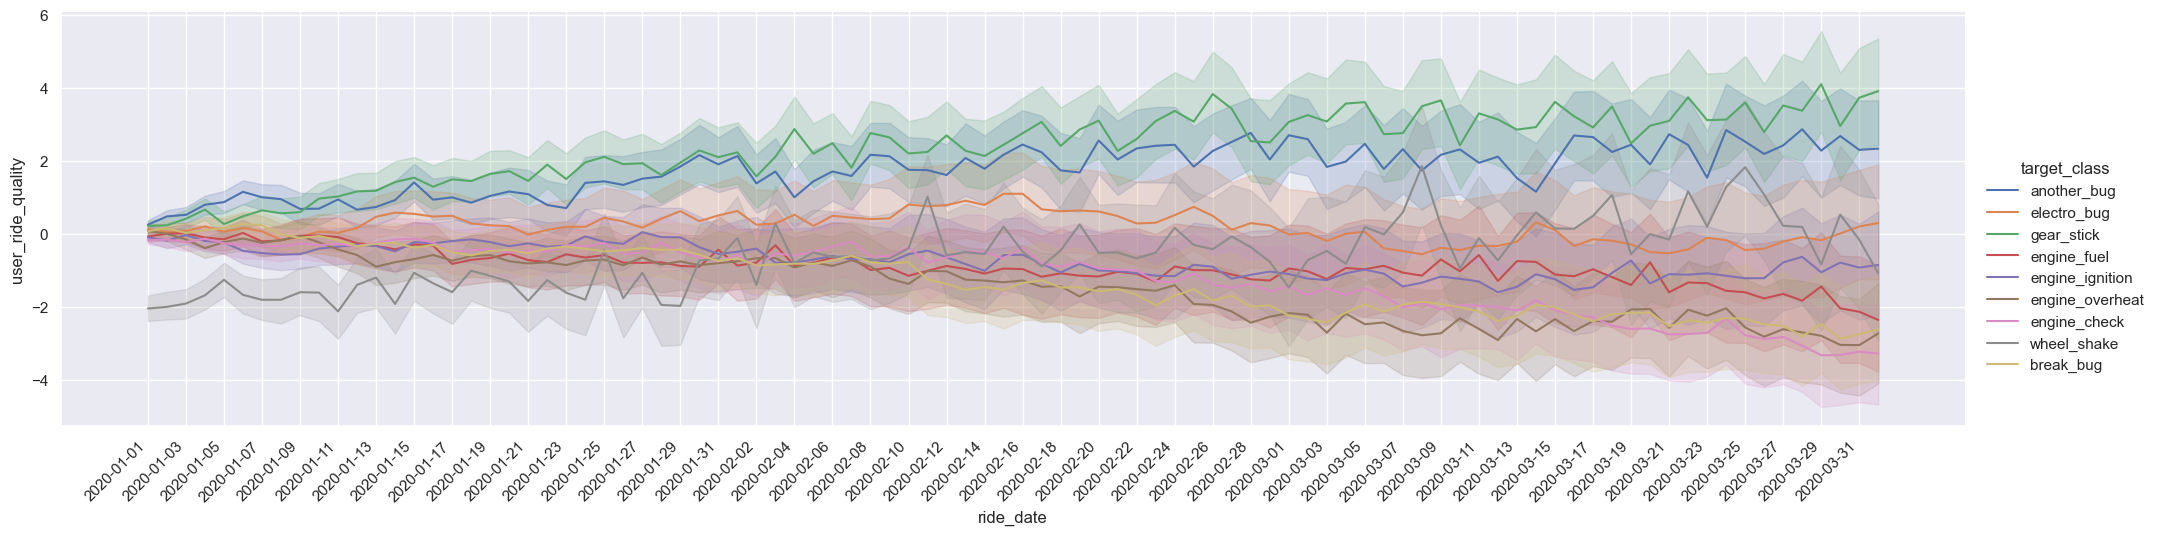

In [8]:
g = sns.relplot(
    data=rides_info_visualization,
    x="ride_date",
    y="user_ride_quality",
    kind="line",
    hue="target_class",
    aspect=4,
)

g.set_xticklabels(rotation=45, horizontalalignment="right", step=2);

### Видны разные тенденции в возникновении поломок от оценки манеры вождения, которые так же могут дать информацию при мультиклассовой классификации

In [9]:
# добавим информацию из датасета fix_info
fix_gr = fix_info.groupby('car_id', axis=False).agg(max_deviation = ('destroy_degree', 'max'),
                                                   mean_destroy_degree = ('destroy_degree', 'mean'),
                                                   std_destroy_degree = ('destroy_degree', 'std'))
rides_info_visualization = rides_info_visualization.merge(fix_gr, on="car_id", how="right")

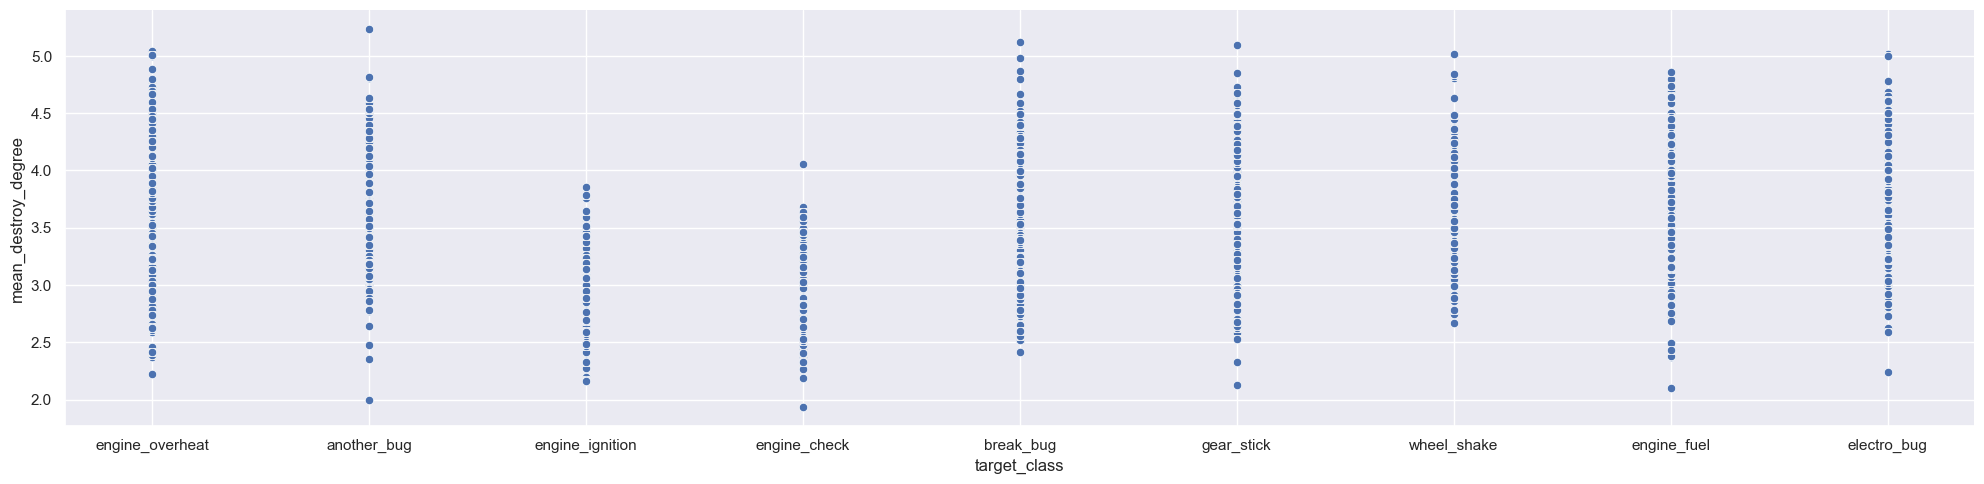

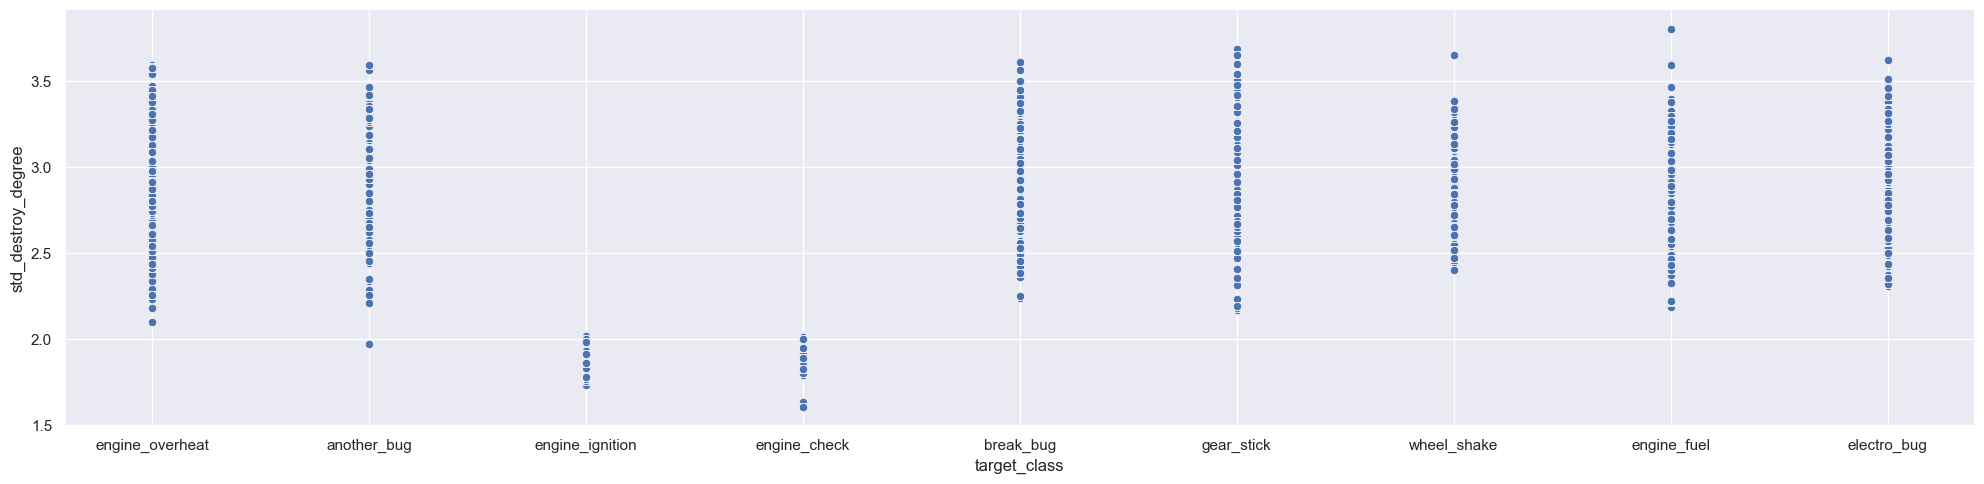

In [10]:
# сэмплируем 100 строк
sample = rides_info_visualization[rides_info["car_id"].isin(rides_info_visualization.sample(100, random_state=10).car_id.unique()[:100])]

g = sns.relplot(
    data=rides_info_visualization,
    x="target_class",    
    y="mean_destroy_degree",    
    kind="scatter",
    aspect=4,
    alpha=1,
)

g = sns.relplot(
    data=rides_info_visualization,
    x="target_class",    
    y="std_destroy_degree",    
    kind="scatter",
    aspect=4,
    alpha=1,
)

### Степень износа может дать полезную информацию модели: среднее и std степени износа для engine ignition и engine check выделяются из общей картины

### Исходя из визуализорования данных добавим несколько фичей: 

In [11]:
rides_gr = rides_info.groupby('car_id', axis=False).agg(min_deviation = ('deviation_normal', 'min'),
                                             max_deviation = ('deviation_normal', 'max'))

fix_gr = fix_info.groupby('car_id', axis=False).agg(mean_destroy_degree = ('destroy_degree', 'mean'),
                                                   std_destroy_degree = ('destroy_degree', 'std'))

def add_features(df):
    
    if 'min_deviation' not in df.columns:
        df = df.merge(rides_gr, on = 'car_id', how = 'left')
        df = df.merge(fix_gr, on = 'car_id', how = 'left')
        df['absolute_difference'] = abs(df['max_deviation'] - df['min_deviation'])
        df['relative_difference'] = (df['min_deviation'] - df['max_deviation']) / 2
    return df

train = add_features(train)
display(train)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,speed_max,user_ride_quality_median,deviation_normal_mean,user_uniq,min_deviation,max_deviation,mean_destroy_degree,std_destroy_degree,absolute_difference,relative_difference
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,180.855726,0.023174,-0.120391,170,-9.000,0.001,3.048571,2.732847,9.001,-4.5005
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,187.862734,12.306011,6.050011,174,-25.088,47.673,2.917143,2.707233,72.761,-36.3805
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,102.382857,2.513319,-2.223954,173,-12.400,4.001,3.740000,2.978077,16.401,-8.2005
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,172.793237,-5.029476,14.771948,170,-12.691,48.956,4.085714,3.237750,61.647,-30.8235
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,203.462289,-14.260456,12.455678,171,-20.907,49.269,3.880000,3.216758,70.176,-35.0880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,j21246192N,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake,...,141.502350,-6.624534,2.914989,171,-10.842,20.808,3.900000,2.785895,31.650,-15.8250
2333,h-1554287F,Audi A4,premium,petrol,4.30,2016,107793,2020,69.26,engine_check,...,155.000000,-8.582467,-18.805856,169,-49.851,5.330,1.935294,1.631115,55.181,-27.5905
2334,A15262612g,Kia Rio,economy,petrol,3.88,2015,80234,2019,46.03,gear_stick,...,104.180940,-0.778524,-7.651776,172,-65.503,41.290,2.782353,2.311168,106.793,-53.3965
2335,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,...,200.000000,2.464975,0.468718,171,-25.038,26.106,3.441176,2.899751,51.144,-25.5720


### Выбрасываем ненужные фичи, определяем категориальные фичи и таргет

In [12]:
drop_features = ['car_id', 'min_deviation', 'max_deviation']
targets = ['target_class', 'target_reg']
categorical_features = ['model', 'car_type', 'fuel_type']
filtered_features = [i for i in train.columns if (i not in targets and i not in drop_features)]

In [13]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = CatBoostClassifier(cat_features=categorical_features)

clf.fit(X_train, y_train, verbose=False)

y_pred = clf.predict(X_test)
print(f'\n Recall: {recall_score(y_test, y_pred, average="macro")}')


 Recall: 0.9184641215755386


### После добавления четырех фич, характеризующих перепад показаний датчиков во времени скор улучшился почти на 12% (скор базлайна 0.80304). Оценим вклад фич в предсказание с помощью feature importance, permutation importance и визуализации, используя библиотеку shap

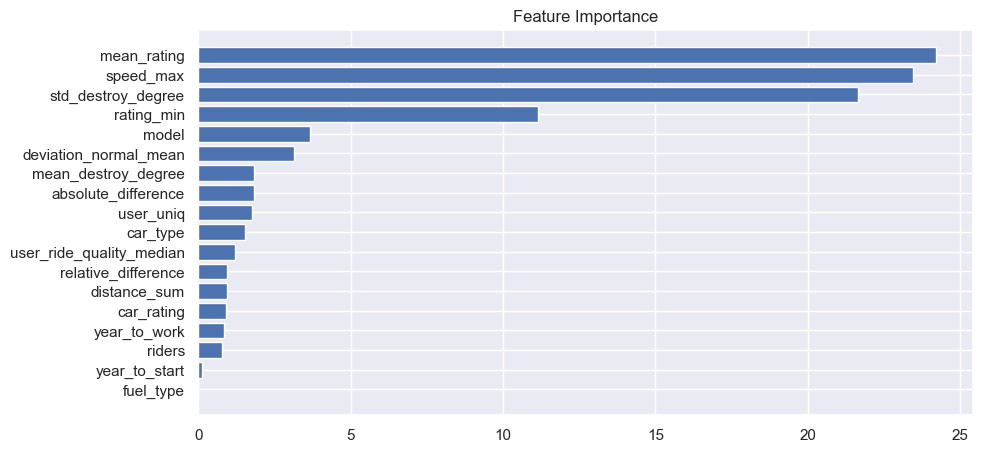

In [14]:
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 5))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance');

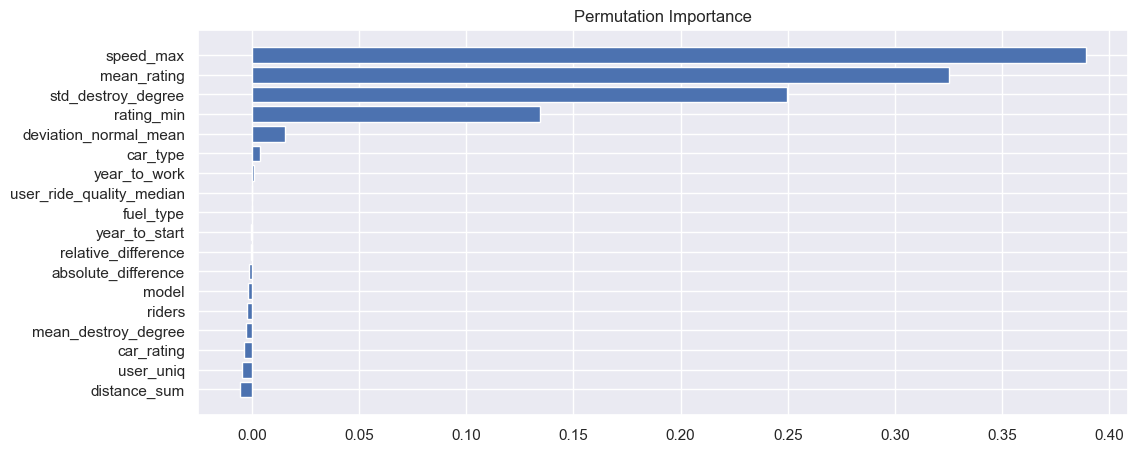

In [15]:
perm_importance = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 5))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance');

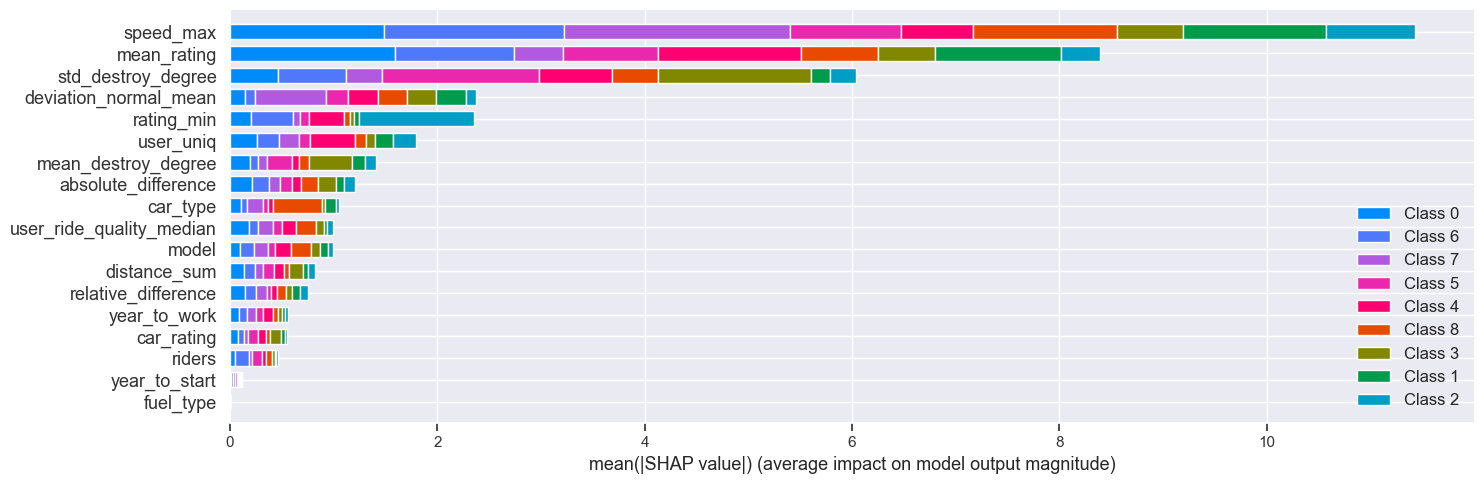

In [16]:
explainer = shap.TreeExplainer(clf)

val_dataset = Pool(data=X_test, label=y_test, cat_features=categorical_features)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display = 25, plot_size = (15, 5))

### Топ 5 по важности у всех методов одинаковый, среди них две добавленные фичи (фича deviation_normal_mean была добавлена в первом ноутбуке). Мы знаем благодаря чему модель хорошо работает, а где модель предсказывает неверно?

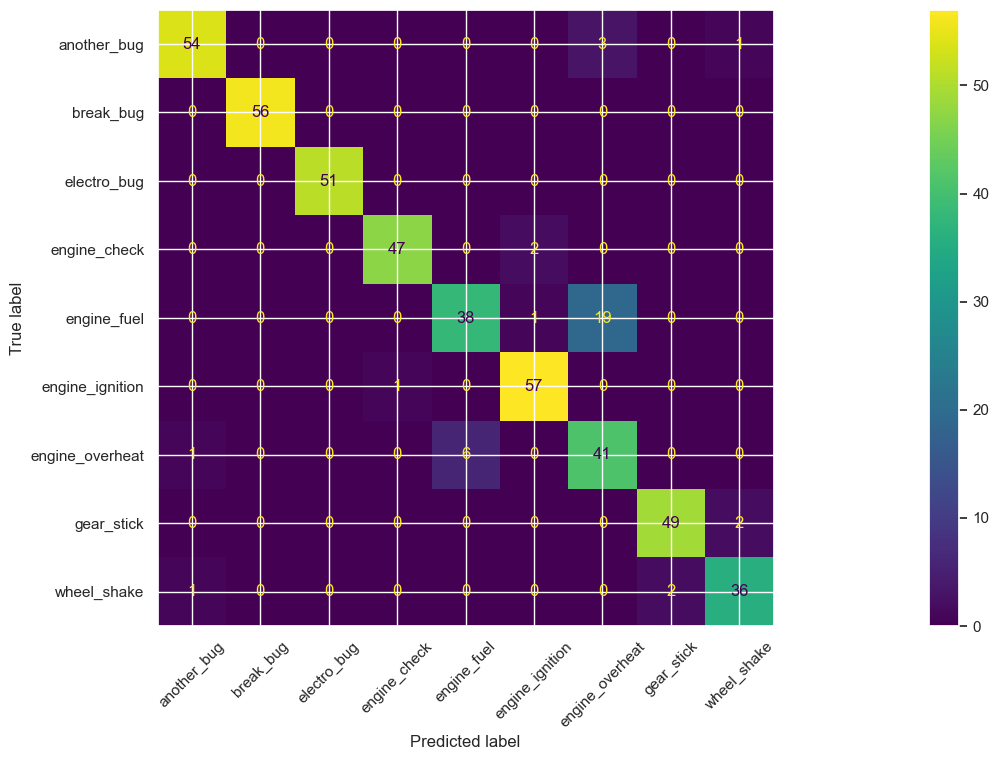

In [17]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, xticks_rotation = 45)

### Модель с ошибками различает engine fuel и engine ignition. С остальными классами проблем практически нет. Попробуем узнать причину

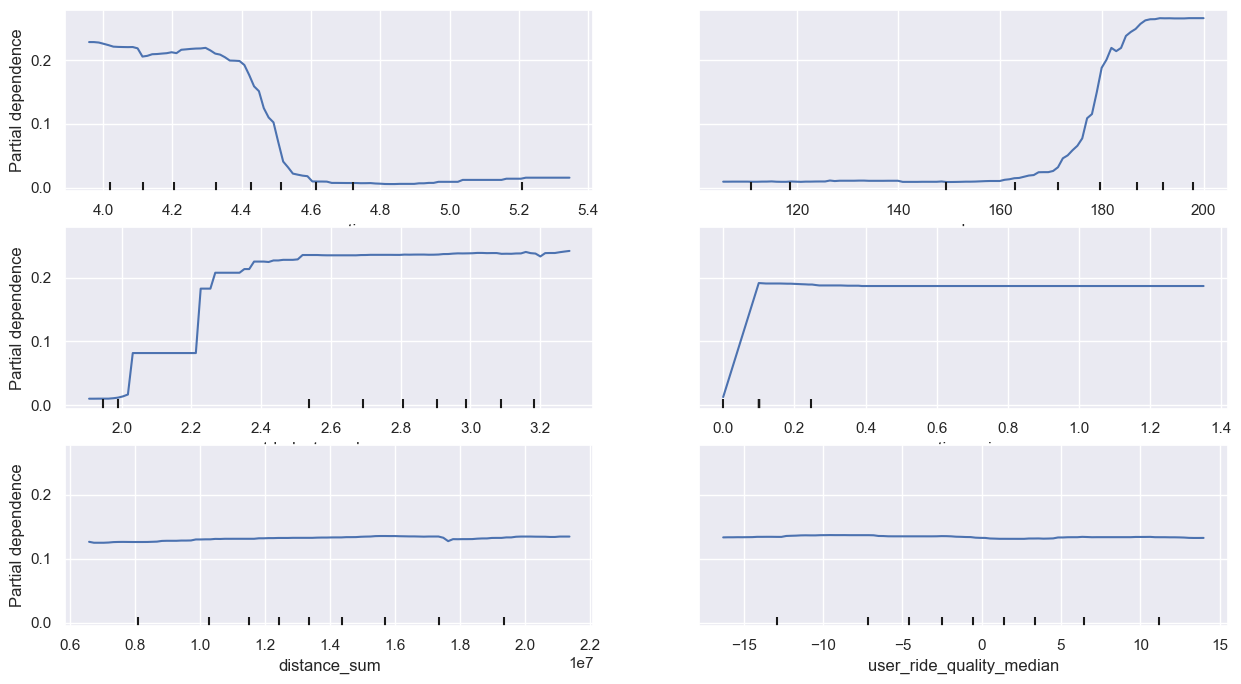

In [18]:
from sklearn.inspection import PartialDependenceDisplay

plt.rcParams['figure.figsize']=(15, 8)
features = X.drop(categorical_features, axis=1).columns

features = ['mean_rating', 'speed_max', 'std_destroy_degree', 'rating_min',
             'distance_sum', 'user_ride_quality_median']

PartialDependenceDisplay.from_estimator(clf, X_test,
                                        features = features,
                                        target='engine_overheat',
                                        n_cols=2,
                                        n_jobs=-1,
                                        random_state=42,);

In [19]:
def search_predictions(y_pred: np.ndarray, 
                             y_test: pd.Series,
                             y_pred_col: str) -> (list[int], list[int]):
    
    y_pred_df = pd.DataFrame(y_pred)
    y_test_df = y_test.reset_index()

    pred_df = y_pred_df[y_pred_df[0] == y_pred_col].index
    pred = y_test_df[y_test_df.index.isin(pred_df)]
    
    false_predictions_index =  pred[pred['target_class'] != y_pred_col].index

    true_predictions_index = pred[pred['target_class'] == y_pred_col].index

    
    return list(false_predictions_index), list(true_predictions_index)
    
false_predictions_index, true_predictions_index = search_predictions(y_pred, 
                                                                     y_test, 
                                                                     'engine_overheat')  
len(false_predictions_index), len(true_predictions_index)

(22, 41)

Верные предсказания


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


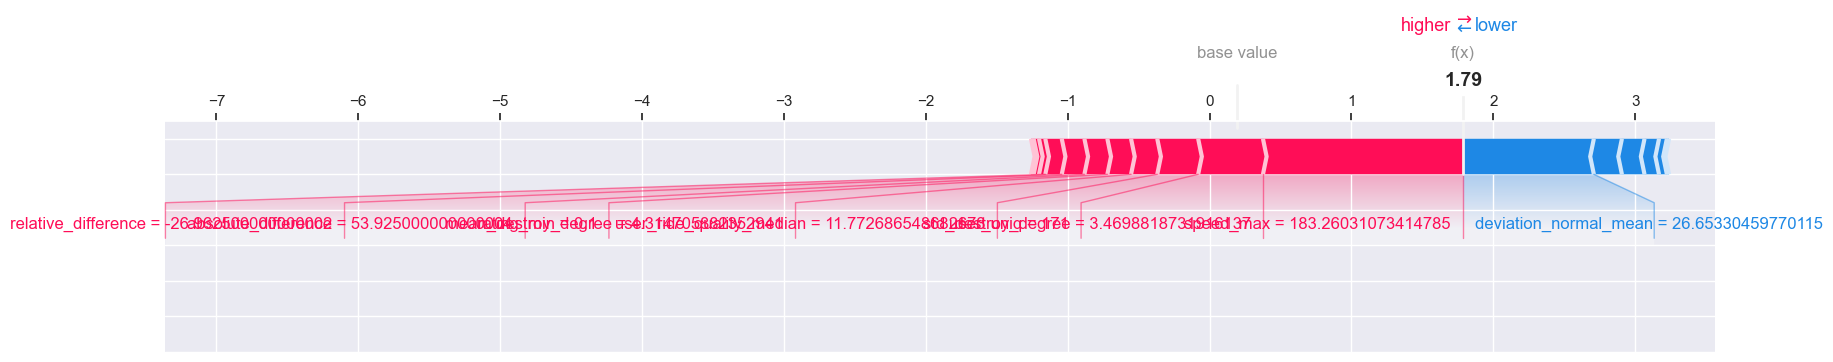

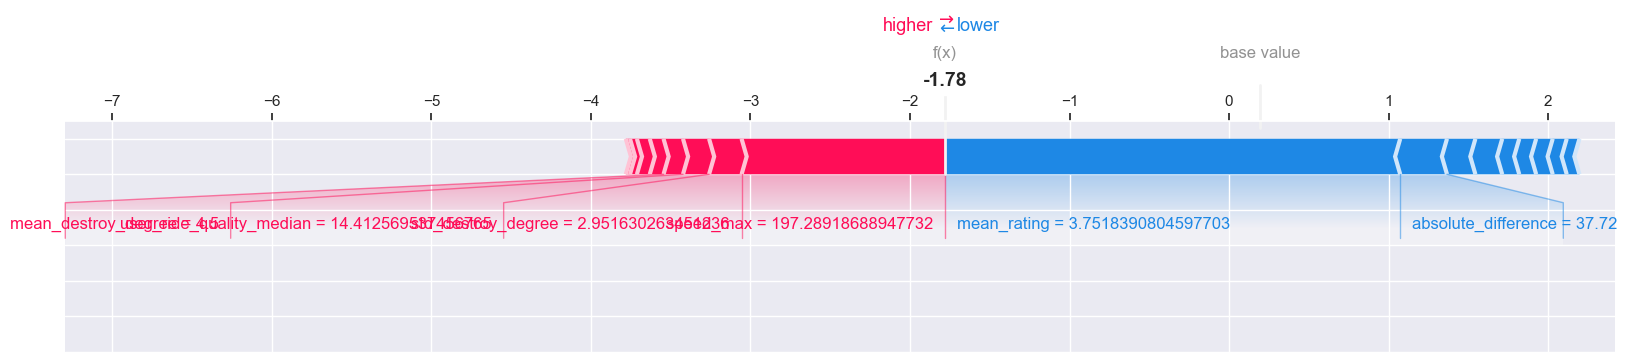

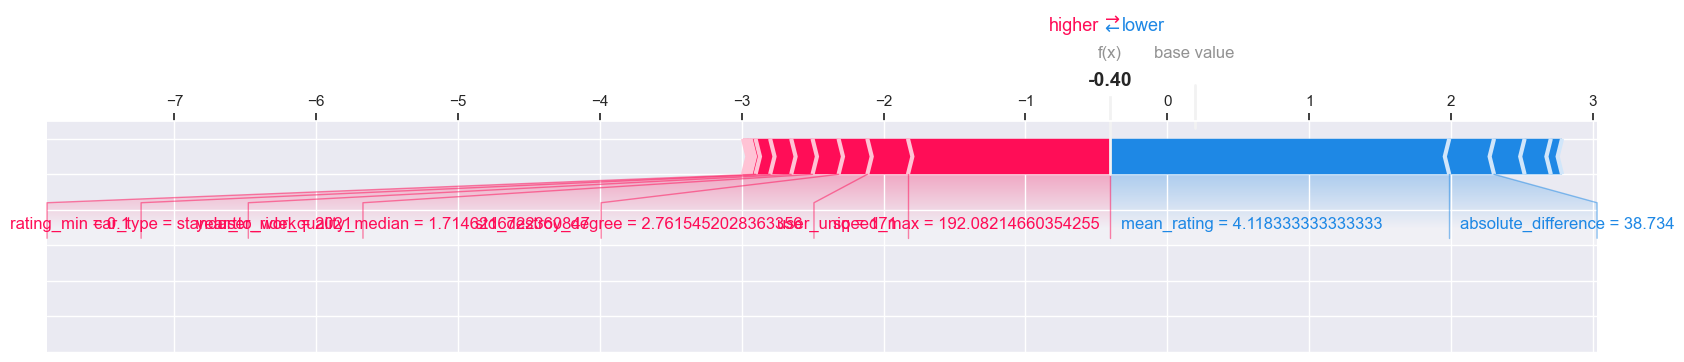

Неверные предсказания


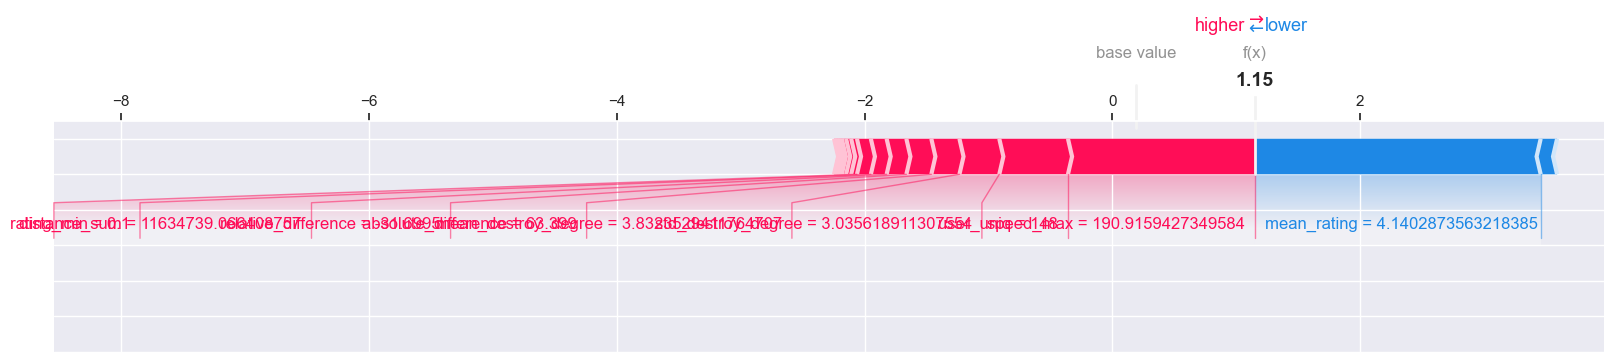

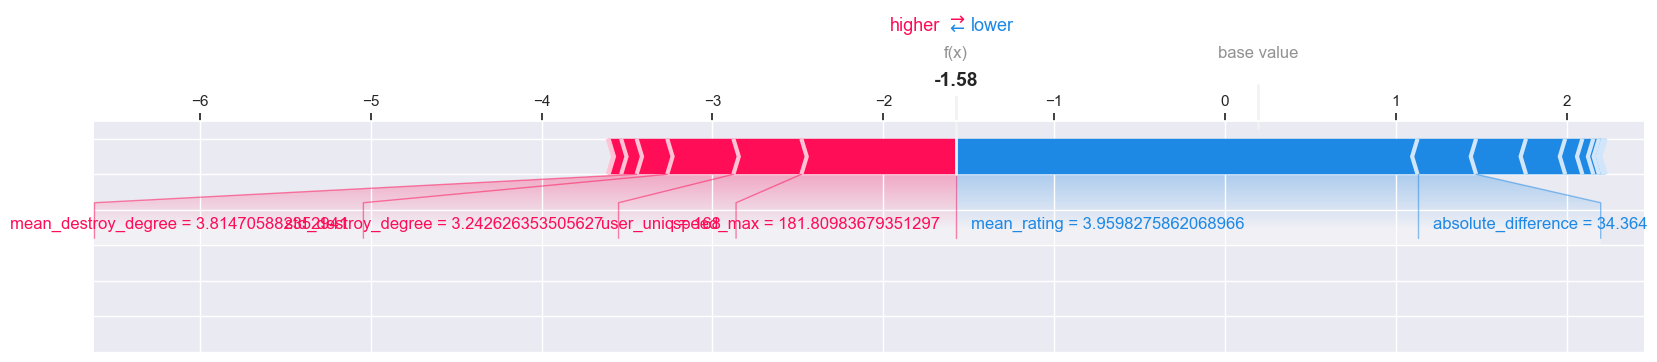

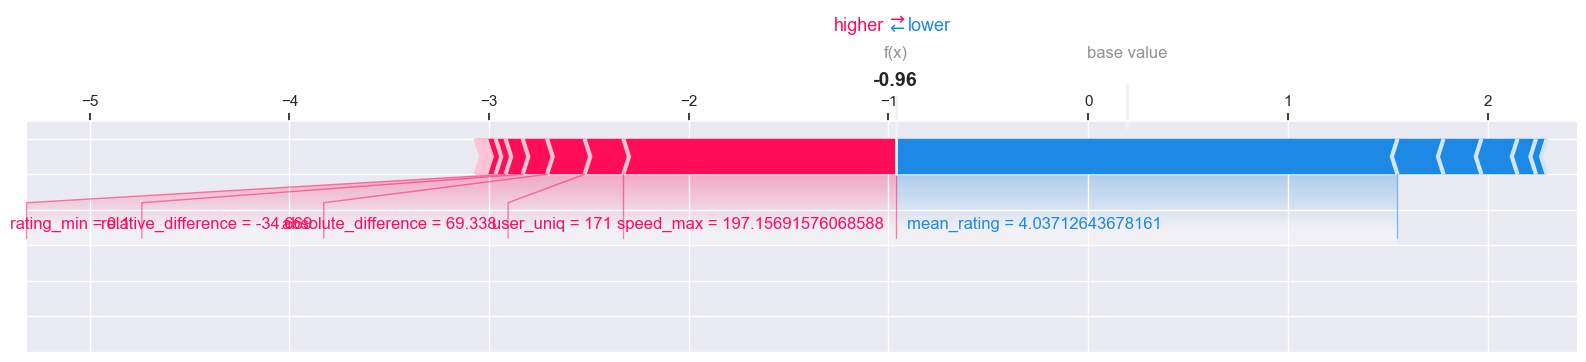

In [20]:
s_values = explainer(X_test)
print('Верные предсказания')
for i in range(3):
    shap.force_plot(s_values[true_predictions_index[i]][:, 0], feature_names=X_test.columns, matplotlib=matplotlib)
print('Неверные предсказания')
for i in range(3):
    shap.force_plot(s_values[false_predictions_index[i]][:, 0], feature_names=X_test.columns, matplotlib=matplotlib)

### Наибольший вклад как в правильное, так и в неправильное предсказания вносят mean_rating и std_destroy_degree. Быть может, стоит добавить больше признаков типа destroy_degree. Может получится лучшая дифференциация классов. 
### Пока что отметим, что после добавления четырех фич, характеризующих перепад показаний датчиков во времени скор улучшился почти на 13% (скор базлайна 0.8017), их вклад виден из feature importance. 
### Посмотрим как с генерацией фичей справится Featuretools:

In [21]:
train.drop(['min_deviation', 'max_deviation'], axis=1, errors='ignore').to_pickle('train')

In [22]:
# создаем сущность, в которой хранятся таблицы и связи между ними
es = ft.EntitySet(id="data_cars")

# добавление в сущность таблиц
es = es.add_dataframe(
    dataframe_name="cars",
    dataframe=train.drop(targets, axis=1, errors='ignore'),
    index="car_id",
    logical_types={"car_type": Categorical, 'fuel_type': Categorical, 'model': Categorical}
    )

es = es.add_dataframe(
    dataframe_name="rides",
    dataframe=rides_info.drop(['ride_id'], axis=1),
    index='index',
    time_index="ride_date",
    )

es = es.add_dataframe(
    dataframe_name="drivers",
    dataframe=driver_info,
    index="user_id",
    logical_types={"sex": Categorical, "first_ride_date": Datetime, "age": Age}
    )

es = es.add_dataframe(
    dataframe_name="fixes",
    dataframe=fix_info,
    index="index",
    logical_types={"work_type": Categorical, "worker_id":Categorical}
    )

# добавление отношений между таблицами
es = es.add_relationship("cars", "car_id", "rides", "car_id")
es = es.add_relationship("drivers", "user_id", "rides", "user_id")
es = es.add_relationship("cars", "car_id", "fixes", "car_id")

es

Entityset: data_cars
  DataFrames:
    cars [Rows: 2337, Columns: 21]
    rides [Rows: 739500, Columns: 14]
    drivers [Rows: 15153, Columns: 7]
    fixes [Rows: 146000, Columns: 7]
  Relationships:
    rides.car_id -> cars.car_id
    rides.user_id -> drivers.user_id
    fixes.car_id -> cars.car_id

In [23]:
feature_matrix, _ = ft.dfs(
    entityset=es,
    target_dataframe_name="cars",
    agg_primitives=["sum", "max", "min"], 
    max_depth=2, 
)

# удаляем константные значения
feature_matrix = ft.selection.remove_single_value_features(feature_matrix) 

feature_matrix.head()

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,mean_rating,distance_sum,rating_min,...,MAX(rides.drivers.user_rides),MAX(rides.drivers.user_time_accident),MIN(rides.drivers.age),MIN(rides.drivers.user_rating),MIN(rides.drivers.user_rides),MIN(rides.drivers.user_time_accident),SUM(rides.drivers.age),SUM(rides.drivers.user_rating),SUM(rides.drivers.user_rides),SUM(rides.drivers.user_time_accident)
car_id,,,,,,,,,,,,,,,,,,,,,
y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,4.737759,1.214131e+07,0.1,...,2626.0,77.0,18.0,6.2,5.0,0.0,5831.0,1432.0,144078.0,2056.0
O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,4.480517,1.803909e+07,0.0,...,2821.0,23.0,18.0,6.7,7.0,0.0,6088.0,1390.0,160916.0,1212.0
d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,4.768391,1.588366e+07,0.1,...,2617.0,25.0,18.0,6.2,1.0,0.0,5714.0,1364.7,163567.0,1701.0
u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,3.880920,1.651883e+07,0.1,...,2626.0,86.0,21.0,8.0,155.0,0.0,6086.0,1483.2,165496.0,2299.0
N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,4.181149,1.398317e+07,0.1,...,2481.0,72.0,18.0,6.5,5.0,0.0,5968.0,1411.5,155944.0,1891.0


In [24]:
filtered_features_ = [i for i in feature_matrix.columns if (i not in targets and i not in drop_features)]

X = feature_matrix[filtered_features_].drop(targets, axis=1, errors='ignore')
y = train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf1 = CatBoostClassifier(cat_features=categorical_features)

clf1.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=150, 
          early_stopping_rounds=5,
          plot=False)

y_pred = clf1.predict(X_test)
print(f'\n Recall: {recall_score(y_test, y_pred, average="macro")}')

Learning rate set to 0.109335
0:	learn: 1.5905137	test: 1.6012139	best: 1.6012139 (0)	total: 81.3ms	remaining: 1m 21s
150:	learn: 0.0063186	test: 0.0101444	best: 0.0101444 (150)	total: 10.6s	remaining: 59.9s
300:	learn: 0.0031103	test: 0.0062401	best: 0.0062383 (299)	total: 21.3s	remaining: 49.5s
450:	learn: 0.0020612	test: 0.0048729	best: 0.0048729 (450)	total: 32.2s	remaining: 39.2s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.004404101102
bestIteration = 544

Shrink model to first 545 iterations.

 Recall: 1.0


In [25]:
importances = clf1.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=X.columns).sort_values()
feature_importances[feature_importances > 0.1]

MAX(fixes.work_duration)                  0.105309
car_type                                  0.125482
MAX(rides.speed_avg)                      0.221118
rating_min                                1.060405
SUM(rides.stop_times)                     2.055976
SUM(rides.rating)                         2.128106
MAX(rides.stop_times)                     2.294934
speed_max                                 3.021149
MAX(rides.speed_max)                      3.421961
SUM(rides.drivers.user_rating)            4.212573
std_destroy_degree                        5.115937
mean_rating                               5.147565
SUM(rides.speed_max)                      6.270441
MIN(rides.rating)                         7.180376
SUM(rides.drivers.user_time_accident)     8.391546
SUM(rides.speed_avg)                     12.537464
MAX(rides.drivers.user_time_accident)    16.320833
MAX(fixes.destroy_degree)                19.596229
dtype: float64

### В данном случае получилось "пробить" задачу. Однако так будет работать не всегда, поэтому возьмем датасет до автогенерации фичей и попробуем повысить скор за счет тюнинга бустингов. 
### P.S. задача взята с кегла, Recall на платформе также 1